# Modelling of catalogue data
This notebook describes how to sample from a catalogue based data set of
- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties)

In [1]:
import numpy as np
#import fastell4py
import time

In [2]:
# the data set is
z_lens = 0.50175
z_source = 2.0

# image positions
ximg = np.array([-0.72406457,  0.30681026,  2.05506938, -0.92206211])  # units of arcsec
yimg = np.array([ 0.74929728, -1.31371359,  0.89928639, -1.10462838])  # units of arcsec
astrometry_sigma = 0.004  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision)

# time delays
# units of days
delay = np.array([162.91199324, 132.58626401,   0.        , 122.28496583])
# lenstronomy definition of relative time delay is in respect of
# first image in the list (full covariance is in planning)
d_dt = delay[1:] - delay[0]
# 1-sigma uncertainties in the time-delay measurement (in units of days)
d_dt_sigma = np.array([2, 2, 2])

# image brightness
# amplitude (in arbitrary linear units, not magnitudes)
image_amps = np.array([0.7265755, 1.5334439,  1.7366254,  3.2545505])
image_amps_sigma = np.array([0.1, 0.5, 0.3, 0.5])
flux_ratios = image_amps[1:] - image_amps[0]
flux_ratio_errors = np.array([0.01, 0.02, 0.03])

## Model settings
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for details.

In [3]:
# lens model choicers
lens_model_list = ['SPEP', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
kwargs_lens_sigma.append({'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]



point_source_list = ['LENSED_POSITION']
fixed_ps = [{'ra_image': ximg, 'dec_image': yimg}]  # we fix the image position coordinates
kwargs_ps_init = fixed_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(ximg)), 'dec_image': 0.01 * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

# we let some freedome in how well the actual image positions are matching those
# given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)
fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000, 'delta_x_image': np.zeros_like(ximg), 'delta_y_image': np.zeros_like(ximg)}
kwargs_cosmo_sigma = {'D_dt': 10000, 'delta_x_image': np.ones_like(ximg) * astrometry_sigma, 'delta_y_image': np.ones_like(ximg) * astrometry_sigma}
kwargs_lower_cosmo = {'D_dt': 0, 'delta_x_image': np.ones_like(ximg) * (-1), 'delta_y_image': np.ones_like(ximg) * (-1)}
kwargs_upper_cosmo = {'D_dt': 10000, 'delta_x_image': np.ones_like(ximg) * (1), 'delta_y_image': np.ones_like(ximg) * (1)}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]


kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'cosmography': cosmo_params}


## setup options for likelihood and parameter sampling

In [4]:
kwargs_constraints = {'num_point_source_list': [4],
                      # any proposed lens model must satisfy the image positions
                      # appearing at the position of the point sources being sampeld
                      'solver_type': 'PROFILE_SHEAR',
                      'cosmo_type': 'D_dt',  # sampling of the time-delay distance
                      # explicit modelling of the astrometric imperfection of the point source positions
                      'point_source_offset': True 
                              }

kwargs_likelihood = {'check_bounds': True,
                     'point_source_likelihood': True,
                     'position_uncertainty': astrometry_sigma,
                     'check_solver': True,
                     'solver_tolerance': 0.001,
                     
                     'time_delay_likelihood': True,
                     'image_likelihood': False, # this needs to be explicitly given when not having imaging data
                     
                     'flux_ratio_likelihood': True  # enables the flux ratio likelihood 
                             }

kwargs_data_joint = {'time_delays_measured': d_dt,
                     'time_delays_uncertainties': d_dt_sigma,
                      'flux_ratios': flux_ratios, 'flux_ratio_errors': flux_ratio_errors}

kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list
                 }

In [5]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [#['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],]

start_time = time.time()
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
471.4532475683628 reduced X^2 of best position
-2121.5396140576327 logL
-9 effective number of data points
[{'theta_E': 1.5148578308761675, 'gamma': 2.3675663105864406, 'e1': -0.001519595889641565, 'e2': 0.052053357241936445, 'center_x': 0.3280638577692184, 'center_y': -0.04034880356521789}, {'e1': 0.0784358610712011, 'e2': 0.24777125406306155, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.72406457,  0.30681026,  2.05506938, -0.92206211]), 'dec_image': array([ 0.74929728, -1.31371359,  0.89928639, -1.10462838]), 'point_amp': 1}] point source result
{'D_dt': 7421.337496087357, 'delta_x_image': array([ 0.03620231,  0.04691948, -0.02381962, -0.05999075]), 'delta_y_image': array([-0.06252718, -0.07610008,  0.04045896,  0.09965439])} cosmo result
80.6505274772644 time used for PSO PSO
80.70448899269104 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS S

In [6]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
222222222222222.22 reduced X^2 of best position
-1000000000000000 logL
-9 effective number of data points
[{'theta_E': 1.514857830876162, 'gamma': 2.3675663105864406, 'e1': -0.0015195958896568652, 'e2': 0.052053357241931206, 'center_x': 0.3280638577691979, 'center_y': -0.04034880356522424}, {'e1': 0.07843586107117992, 'e2': 0.2477712540630683, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.72406457,  0.30681026,  2.05506938, -0.92206211]), 'dec_image': array([ 0.74929728, -1.31371359,  0.89928639, -1.10462838]), 'point_amp': 1}] point source result
{'D_dt': 7421.337496087357, 'delta_x_image': [0.03620230961220174, 0.04691948241033116, -0.023819615389429283, -0.059990751802453654], 'delta_y_image': [-0.06252718158918932, -0.07610008119652104, 0.040458956338645505, 0.09965439079236185]} cosmo result
44.89160990715027 time used for PSO PSO
Computing the MC

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
259.697345495224 time taken for MCMC sampling


In [26]:
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_cosmo=fixed_cosmo, 
              kwargs_lens_init=lens_result, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.lens_analysis import LensAnalysis
lensAnalysis = LensAnalysis(kwargs_model)

mcmc_new_list = []
labels_new = [r"$\gamma$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$\theta_{E}$", r"$D_{\Delta t}$"]
D_dt = np.zeros(len(samples_mcmc))
theta_E = np.zeros(len(samples_mcmc))
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out, kwargs_cosmo = param.args2kwargs(
        samples_mcmc[i])
    D_dt[i] = kwargs_cosmo['D_dt']
    gamma = kwargs_lens_out[0]['gamma']
    theta_E[i] = kwargs_lens_out[0]['theta_E']
    e1 = kwargs_lens_out[0]['e1']
    e2 = kwargs_lens_out[0]['e2']
    phi_ext, gamma_ext = lensAnalysis._lensModelExtensions.external_shear(kwargs_lens_out)
    mcmc_new_list.append([gamma, phi_ext, gamma_ext, theta_E[i], D_dt[i]])


number of non-linear parameters in the MCMC process:  12
parameters in order:  ['gamma_lens', 'e1_lens', 'e2_lens', 'D_dt', 'delta_x_image', 'delta_x_image', 'delta_x_image', 'delta_x_image', 'delta_y_image', 'delta_y_image', 'delta_y_image', 'delta_y_image']
number of evaluations in the MCMC process:  24000


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/lenstronomy/__init__.py
24000 7183.727058347022 3084.7745025636614
0.32417280393394415


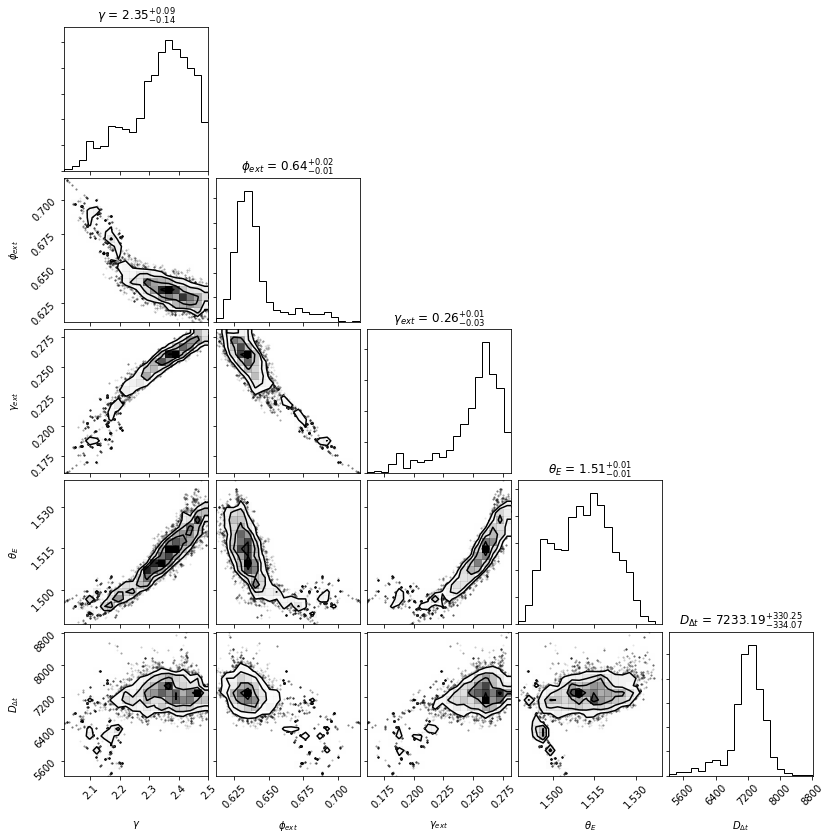

In [32]:
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

# and here the predicted angular diameter distance from a default cosmology (attention for experimenter bias!)
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy
print(lenstronomy.__file__)
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
best = 7200

D_dt_best = np.mean(D_dt)
print(len(D_dt), D_dt_best, lensCosmo.D_dt)
print(1/lensCosmo.D_dt * 1000)
